# Transfer Learning DenseNet201 Pre-trained model TL_DN_M1



## 1. Importing and loading the preprocessed dataset

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


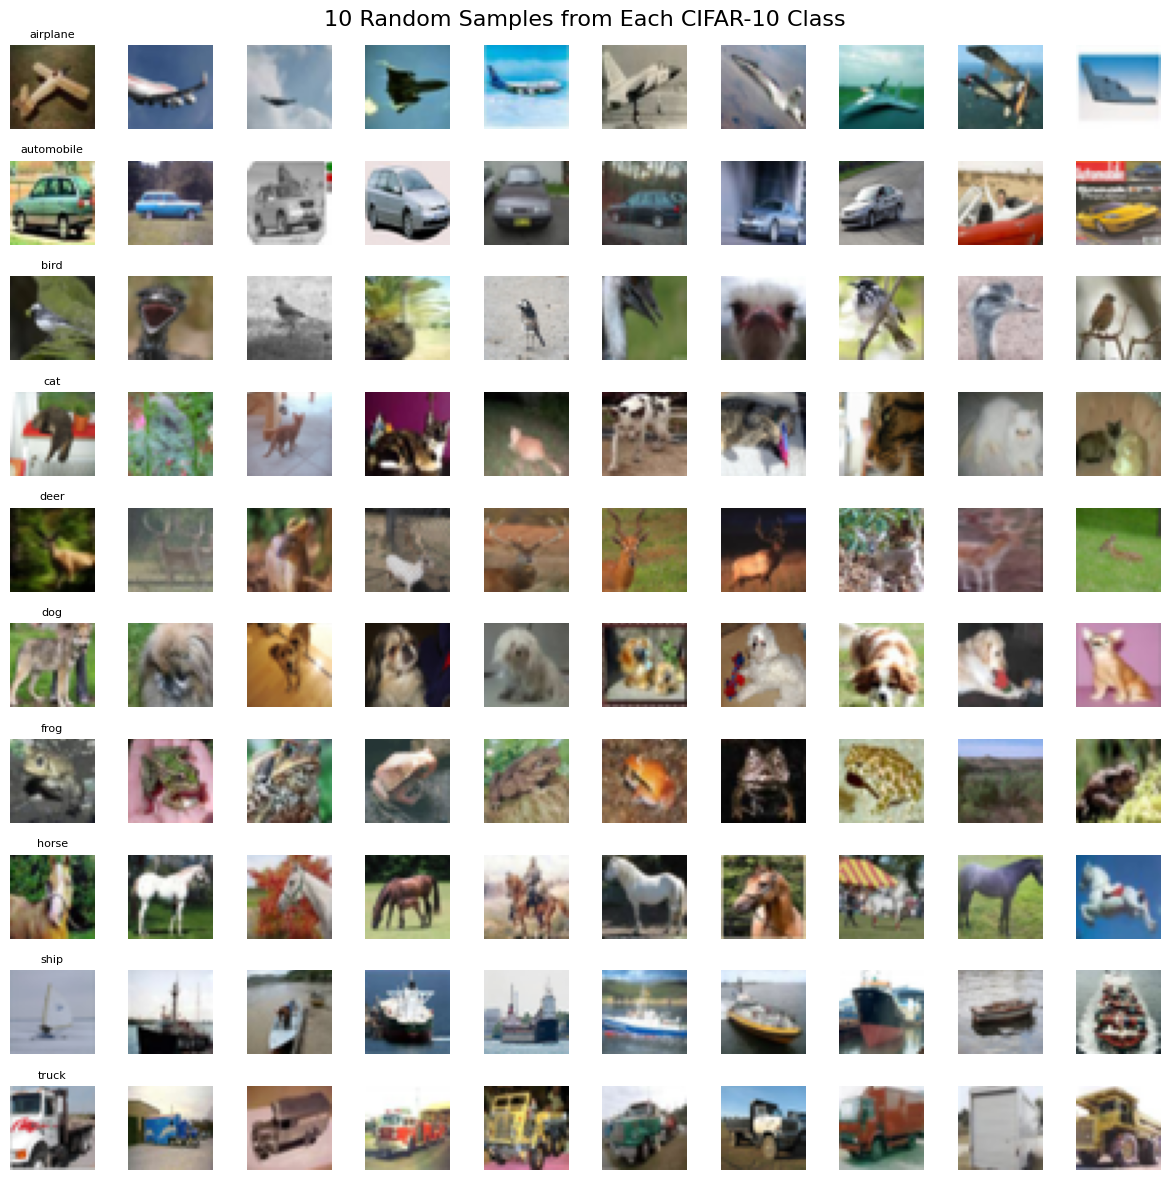

In [1]:
import nbformat
from IPython.core.interactiveshell import InteractiveShell

with open('preprocessing.ipynb') as f:
    nb = nbformat.read(f, as_version=4)

shell = InteractiveShell.instance()
for cell in nb.cells:
    if cell.cell_type == 'code':
        shell.run_cell(cell.source)

 ## 2. Model building

In [2]:
# First we will clear the keras session
from keras.backend import clear_session
clear_session()


#### 2.1 Loading the DenseNet201 pre-trained model from Keras

In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras import layers, models

# Load DenseNet201, excluding the top (classification) layers
base_model = DenseNet201(input_shape=(224, 224, 3),
                         include_top=False,
                         weights='imagenet')

# We set the base model to be trainable as we will unfreeze some of the top layers, so that they can be trained.

base_model.trainable = True  


74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### 2.2 Creating training and testing datasets, for which we can apply image resizing

In [ ]:
import tensorflow as tf
# Setting image size to the input  shape of DenseNet201, so that we can re-size the images from CIFAR-10 data set.
IMG_SIZE = 224

# Create a tf.data.Dataset from our training and testing data
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Define a function to resize images
def resize_image(image, label):
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    return image, label

# Apply the resizing function to the datasets, we've created
train_ds = train_ds.map(resize_image)
test_ds = test_ds.map(resize_image)

# We define the batch_size we want to use when fitting the model. Also, we use 'prefetch' method to speed up the training process.
batch_size = 64
train_ds = train_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# Freeze only the first N layers
N = 150  # We will freeze the first 150 layers and let the others to be trained based on the CIFAR-10 training data. 
for layer in base_model.layers[:N]:
    layer.trainable = False
for layer in base_model.layers[N:]:
    layer.trainable = True

#### 2.3 Defining model architecture

We will use DenseNet201 as the base layer, followed by a pooling layer to reduce the tensor shape (GlobalAveragePooling2D). We have used GlobalAveragePooling2D because, despite MaxPooling2D is great for downsampling and feature selection within the convolutional layers, GlobalAveragePooling2D is often preferred as the final pooling layer before classification because it provides a more robust and parameter-efficient way to summarize the extracted features across the entire image, reducing the risk of overfitting. 

Finally, on top of it we will add a Dense layer with Relu activation and 128 neurons, a dropout 0.5 layer and finally the output layer with softmax activation.

In [ ]:
model = models.Sequential([
    base_model,                                      # Pretrained model (DenseNet201)
    layers.GlobalAveragePooling2D(),                 # Reduce tensor shape
    layers.Dense(128, activation='relu'),            # Custom dense layer
    layers.Dropout(0.5),                             # Regularization
    layers.Dense(10, activation='softmax')           # Output layer
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       245,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,569,162 (70.84 MB)

 Trainable params: 16,839,498 (64.24 MB)

 Non-trainable params: 1,729,664 (6.60 MB)

## 3. Model training

#### 3.1 Compiling and fitting the model

In [ ]:

# Compiling the model using the defined parameters:

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train only the new classification head
history = model.fit(train_ds, epochs=5, validation_data=test_ds)


Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1115s 976ms/step - accuracy: 0.7539 - loss: 0.7791 - val_accuracy: 0.8304 - val_loss: 0.5215
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 501s 613ms/step - accuracy: 0.8835 - loss: 0.3707 - val_accuracy: 0.8991 - val_loss: 0.3038
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 478s 611ms/step - accuracy: 0.9127 - loss: 0.2762 - val_accuracy: 0.9020 - val_loss: 0.3237
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 502s 611ms/step - accuracy: 0.9300 - loss: 0.2211 - val_accuracy: 0.9076 - val_loss: 0.3140
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 500s 609ms/step - accuracy: 0.9467 - loss: 0.1696 - val_accuracy: 0.9052 - val_loss: 0.3376


#### 3.2 Plot training history (loss/accuracy curves)

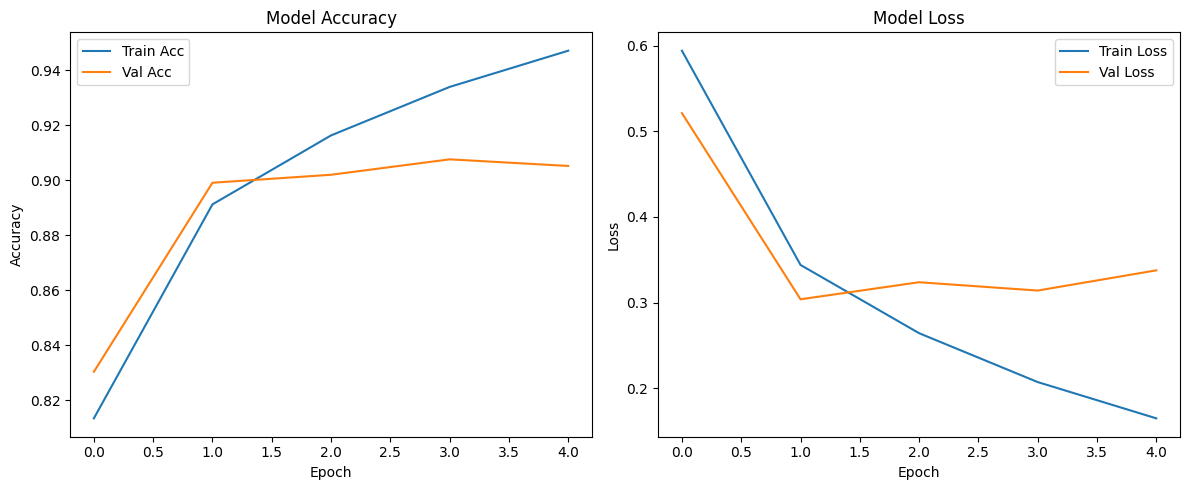

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## 4. Model evaluation

#### 4.1 Evaluate on the test set

In [ ]:
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f'Test accuracy: {test_acc:.4f}')
print(f'Test loss: {test_loss:.4f}')

Test accuracy: 0.9052
Test loss: 0.3376


#### 4.2 Calculate metrics: Precision, recall, F1 score

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

# Get predictions from the model
y_pred = model.predict(test_ds)

# Convert one-hot encoded labels and predictions to class indices
y_test_classes = np.argmax(y_test, axis=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate precision, recall, and F1 score, using 'macro' average, as the classes are balanced (6k images per class)
precision = precision_score(y_test_classes, y_pred_classes, average='macro')
recall = recall_score(y_test_classes, y_pred_classes, average='macro')
f1 = f1_score(y_test_classes, y_pred_classes, average='macro')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 74s 347ms/step
Precision: 0.9080
Recall: 0.9052
F1 Score: 0.9058


#### 4.3 Confusion matrix and classification report

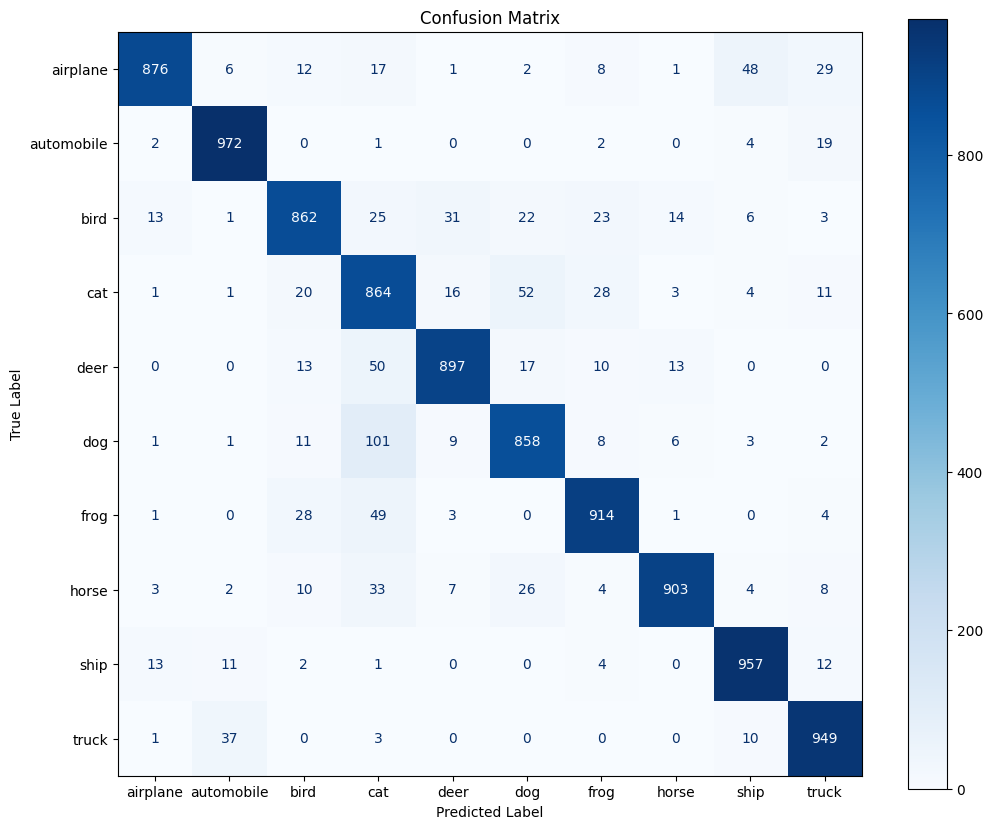

Classification Report:
              precision    recall  f1-score   support

    airplane       0.96      0.88      0.92      1000
  automobile       0.94      0.97      0.96      1000
        bird       0.90      0.86      0.88      1000
         cat       0.76      0.86      0.81      1000
        deer       0.93      0.90      0.91      1000
         dog       0.88      0.86      0.87      1000
        frog       0.91      0.91      0.91      1000
       horse       0.96      0.90      0.93      1000
        ship       0.92      0.96      0.94      1000
       truck       0.92      0.95      0.93      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import seaborn as sns

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Compute confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
fig, ax = plt.subplots(figsize=(12, 10))
disp.plot(cmap='Blues', ax=ax)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

## 5. Results and conclusion

The results from this notebook demonstrate that applying transfer learning with a pre-trained DenseNet201 model on the CIFAR-10 dataset leads to strong classification performance, especeially when performing fine tuning (unfreezing some of the base pre-trained model layers). By freezing the first 150 layers of the DenseNet201 base and fine-tuning the remaining layers, the model quickly achieves high accuracy (90.52%) and low loss (0.3376) after just five epochs of training. The evaluation metrics, including precision, recall, and F1 score, are consistently high and balanced across all classes, indicating that the model generalizes well and does not suffer from significant class imbalance issues. The confusion matrix and classification report further confirm that the model performs reliably across all categories, with only minor misclassifications between similar classes (especially cats and dogs). These results highlight the effectiveness of transfer learning for image classification tasks, showing that leveraging pre-trained models can yield excellent results with limited training time and data. 

Extending training could potentially improve performance even further, but er have to be aware of overfitting risk. In this model we've already seen some indications of overfitting, by looking at the gap between training and validation curves for both accuracy and loss curves. The divergenvce ends up being 0.04 between the accuracy curves and 0.17 between the loss curves. We will see its impact during the next iterations.

In [ ]:
#model.save('TL_DN201_M1.keras')